# import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from datetime import datetime
from urllib.request import urlopen


from bs4 import BeautifulSoup
from requests import get


# scrape all pages

In [29]:
def scrape_housing_data(url = "https://sfbay.craigslist.org/search/apa?availabilityMode=0", studiobedrooms = 1.0):
    
    """
    Args:
        url: url of the webpage to scrape. Defaults to bay area craigslist.
        
    Returns:
        dataframe with (almost) raw scraped data (with minor cleaning)
    
    """
    
    html = urlopen(url)
    soup = BeautifulSoup(html,'html')
    

    # define ranges
    rangefrom=int(soup.find(class_="rangeFrom").text)  # starting index for listings
    rangeto=int(soup.find(class_="rangeTo").text)  # ending index for listings
    perpage = rangeto-rangefrom+1  # listings per page
    totalcount = int(soup.find(class_="totalcount").text)  # total number of listings
    
    
    
    #initialize lists of info:
    links=[]  # url links for each listing
    descs=[]  # description for each listing
    prices=[]  # price for each listing
    sqfeets=[]  # square feet for each listing
    bedrooms = []  # number of bedrooms for each listing
    hood=[]  # neighborhood for each listing

    
    #for each page, make a soup, and for each listing in that soup, append to each info list. 
    for i in range(0,totalcount,perpage):
        url = "https://sfbay.craigslist.org/search/apa?availabilityMode=0&s="+str(i)


        response = get(url)
        soup = BeautifulSoup(response.text,'html')
        resultrows = soup.find_all(class_="result-row");

        ###
        for row in resultrows:

            #hyperlink:
            linki = row.find(class_='result-title hdrlnk')['href']
            links.append(linki)

            #description (or title) of listing:
            description = row.find(class_='result-title').text
            descs.append(description)

            #price:
            try:
                price=float(  re.compile('[\d]+').search( row.find(class_='result-price').text   ).group()   )
                prices.append(price)
            except:
                prices.append(np.NaN)

            #number of bedrooms and square footage:
            try:
                housinginfo = row.find(class_='housing').text
                #bedrooms:
                try: #check whether # of bedrooms is given in the "housing" class:
                    br = float(re.compile('\d').search(  re.compile('\dbr').search(housinginfo).group()  ).group()  ) #this mess pulls out number of bedrooms
                except AttributeError: #if not, try to find bedroom number in description:
                    try: 
                        br=re.compile('\d').search(re.compile('(\dbr|\d-br|\d\sbr|\dbdr|\d-bdr|\d\sbedroom|\d-bedroom)').search(description.lower()).group()).group()

                    except: #or maybe the description says it's a studio:
                        stud=re.compile('studio').search(description.lower())
                        if stud is not None:
                            br = studiobedrooms
                        else:
                            br=np.NaN
                #square footage:
                try: #check whether square footage is given in "housing" class:
                    sqfeet = float(re.compile('[\d]+').search( re.compile('[\d]+ft2').search(housinginfo).group() ).group()   )
                    sqfeets.append(sqfeet)
                except AttributeError: #if not, mark "nan" and move on.
                    sqfeets.append(np.NaN)
            except AttributeError: #in case 'housing' class doesn't exist for the listing:
                sqfeets.append(np.NaN) #give up on square footage
                #
                try: #try to find number of bedrooms in description:
                    br=re.compile('\d').search(re.compile('(\dbr|\d-br|\d\sbr|\dbdr|\d-bdr|\d\sbedroom|\d-bedroom)').search(description.lower()).group()).group()
                except: #if no appearance of "br" in description, look for "studio":
                    stud=re.compile('studio').search(description.lower())
                    if stud is not None:
                        br = studiobedrooms
                    else:
                        br=np.NaN
            finally: #br has now been defined, even if as "nan"
                bedrooms.append(float(br))


            #neighborhood
            try:
                nh = re.compile('[^)^(]+').search(  row.find(class_='result-hood').text.strip().lower()  ).group()        
                hood.append(nh)
            except:
                hood.append(np.NaN)



        time.sleep(3) #take a break before scraping the next page
        
    raw_scraped_data = pd.DataFrame({'url': links, 'description': descs, 'price': prices, 'square_feet': sqfeets, 'bedrooms': bedrooms, 'neighborhood': hood})
    return raw_scraped_data


In [30]:
raw_scraped_data = scrape_housing_data()

In [59]:
# # i think i'm not using this??

# # when "neighborhood" is an address, extract just the city
# def address_to_neighborhood(nh):

#     """
#     Convert an input 'neighborhood' that may be a combination of neighborhoods, and may contain street address, into only neighborhoods.
    
#     Args:
#         nh: a string, which may contain '/' and digits.
        
#     Returns:
#         Only the pieces that contain no digits, separated by slashes if they were before:
    
#         e.g. "2000 Market St., San Francisco/ Nob Hill" would become 'Nob Hill', and "San Francisco/ Nob Hill" would become 'San Francisco/Nob Hill'    
#     """

#     combohood = re.compile('/').search(nh)
#     if combohood is not None: # i.e. if a slash appears in the neighborhood
#         pieces= (re.compile("[^/]+").findall(nh)) # list constituent neighborhoods
#         pieces = [p.strip() for p in pieces if re.compile('[\d]+').search(p)==None] # strip each entry, and include only if it contains no digits
#         if 'downtown' in pieces:
#             pieces.remove('downtown')  # remove if one of the "neighborhoods" is "downtown"

#     return '/'.join(pieces)



# cleaning

## some test stuff (move later)

In [70]:
import unittest

class test_helpers(unittest.TestCase):
    
    
    def test_address_to_neighborhood(self):

        self.assertEqual( address_to_neighborhood('134 Mandela/Oakland / Berkeley/ San Francisco'), 'Oakland/Berkeley/San Francisco')
    
    

## given the dataframe, produce a cleaned list of the represented neighborhoods 

In [343]:
def get_cleaned_neighborhoods(scraped_data):
    
    """
    Produce a list from scraped_data['neighborhood'] with no null values, no street addresses, and no slashes, e.g. separate "richmond/antioch" to "richmond", "antioch"
    
    Args:
        scraped_data: dataframe with a column 'neighborhood' containing strings and np.nan
        
    Returns:
        list of strings
    
    """
    
    raw_nh_list = [nh for nh in list(set(scraped_data['neighborhood'].dropna())) if re.compile('[\d]').search(nh) is None]
    
    nested_nh_list = [nh.split('/') for nh in raw_nh_list]  # split on '/'
    ## also split on ',' ?
    nh_list = [x.strip().lower() for nh in nested_nh_list for x in nh]  # flatten the list
    nh_list = [x for x in nh_list if re.compile('[\d]').search(x) is None]  # lose the elements containing digits
    nh_list = [x for x in nh_list if x != 'downtown'] # remove 'downtown'
    return nh_list
    
    

def extract_neighborhood(description, neighborhoods_list):
    
    """
    Search for any of the elements of neighborhoods_list in description.
    
    Args:
        description: text string
        neighborhoods_list: list of strings
        
    Returns:
        the first element of neighborhoods_list that appears in desctription.
    
    """
    
    description = description.lower()
    neighborhoods_list = [x.lower() for x in neighborhoods_list]
    
    orhoods = r'(\b'+(r'\b|\b'.join(neighborhoods_list))+r'\b)'
    
    nh_in_description = re.compile(orhoods).search(description)
    
    if nh_in_description is not None:
        nh = nh_in_description.group()
#         print(f"found {nh} in description {description}")
    else:
        nh = np.nan
        
    return nh
    

def fill_neighborhood_from_description(scraped_data):
    
    """
    Operates on the full dataframe.
    If missing data in 'neighborhood' column of scraped_data, check for 'neighborhood' from any row in 'description' column.
    
    Args:
        scraped_data: dataframe, must have columns ['description', 'neighborhood']
        
    Returns:
        copy of scraped_data with missing 'neighborhood' values filled using description, when possible.
    
    functional dependencies:
        get_cleaned_neighborhoods
        extract_neighborhood
    """
    
    df = scraped_data.copy()
    
    neighborhoods_list = get_cleaned_neighborhoods(scraped_data)
#     neighborhoods_list = list(set(scraped_data['neighborhood'].dropna()))

    
    df['neighborhood'] = df.apply(lambda row: extract_neighborhood(row['description'], neighborhoods_list) if str(row['neighborhood'])=='nan' else row['neighborhood'], axis = 1)

        
    return df

In [295]:
# filled_nh = fill_neighborhood(raw_scraped_data)

In [296]:
# neighborhoods_list = list(set(raw_scraped_data['neighborhood'].dropna()))
# description = raw_scraped_data.loc[62,'description']
# extract_neighborhood(description, neighborhoods_list)


In [339]:
# # inspect the rows of filled_nh that were missing neighborhood info in raw_scraped data, and note some are now filled:
# filled_nh.loc[raw_scraped_data['neighborhood'].isna()]

In [344]:
# nh_list = get_cleaned_neighborhoods(raw_scraped_data)

In [361]:
def street_address_to_neighborhood(possible_street_address, neighborhoods_list):
    """
    If possible_street_address is not contained in neighborhoods_list, return whichever part of it is (if any).
    Args:
        possble_street_address: string, possibly containing digits
        neighborhoods_list
    Returns:
        string
        
    """
#     possible_street_address = possible_street_address.lower()
    neighborhoods_list = [x.lower() for x in neighborhoods_list]
    
    orhoods = r'(\b'+(r'\b|\b'.join(neighborhoods_list))+r'\b)'

    
    if (possible_street_address not in neighborhoods_list) and (str(possible_street_address) != 'nan'):
        
        neighborhood_within_address = re.compile(orhoods).findall(possible_street_address.lower())
        if neighborhood_within_address != []:
            
            return('/'.join(neighborhood_within_address))
        
        else:
            return np.nan
        
    else:
        return possible_street_address
        


In [362]:
# # test
# street_address_to_neighborhood('132 Mandela Pkwy, Oakland hills', nh_list)
# street_address_to_neighborhood('oakland hills', nh_list)

In [363]:
def convert_street_addresses(scraped_data):
    
    """
    Operates on the full dataframe.
    
    If scraped_data['neighborhood'] is not in the cleaned list of neighborhoods (e.g. because it has digits in it),
    check whether it contains any of the cleaned neighborhoods. If so, replace with that. If not, replace with np.nan.
    
    Args:
        scraped_data: dataframe with column ['neighborhood']
        
    Returns:
        copy of scraped_data with 'neighborhood' replaced by np.nan if it contained digits
    
    """
    clean_nh_list = get_cleaned_neighborhoods(scraped_data)
    
    df = scraped_data.copy()
    
    df['neighborhood'] = df['neighborhood'].apply(lambda nh: street_address_to_neighborhood(nh, clean_nh_list))
    
    return df

In [386]:
# cleaner_data = convert_street_addresses(raw_scraped_data)

# # raw_scraped_data[raw_scraped_data != cleaner_data]

In [387]:
# list(set(cleaner_data['neighborhood']))

In [334]:
# raw_scraped_data.loc[15]

In [335]:
# cleaner_data.loc[15]

# use scraped info about sf and oakland neighborhoods to lump:

As pulled from Craigslist, "San Francisco" is broken down into many neighborhoods. I would like to lump these all into "san francisco", so I can have enough samples per neighborhood to do statistics.

I'll try scraping neighborhood names from Wikipedia:

In [371]:
urlsfnh="https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco"

htmlsfnh=urlopen(urlsfnh)

soupsfnh = BeautifulSoup(htmlsfnh,'html')

allsections=soupsfnh.select('.toclevel-1')

sfhoods=[];
for sec in allsections:
    sfhoods.append(re.compile("[a-z\s/'-]+").search(sec.text.lower()).group().strip())
    
sfhoods = [nh for nh in sfhoods if nh.lower() not in ['see also','references', 'external links']]

In [372]:
urloak="https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Oakland,_California"

htmloak=urlopen(urloak)

soupoak = BeautifulSoup(htmloak,'html')

allsections=soupoak.select('.toclevel-1')

oakhoods=[];
for sec in allsections:
    oakhoods.append(re.compile("[a-z\s/'-]+").search(sec.text.lower()).group().strip())
    
oakhoods=[nh for nh in oakhoods if nh.lower() not in ['see also','references', 'external links']]

In [373]:
sfhoods

['alamo square',
 'anza vista',
 'ashbury heights',
 'balboa park',
 'balboa terrace',
 'bayview',
 'belden place',
 'bernal heights',
 'buena vista',
 'butchertown',
 'castro',
 'cathedral hill',
 'cayuga terrace',
 'china basin',
 'chinatown',
 'civic center',
 'clarendon heights',
 'cole valley',
 'corona heights',
 'cow hollow',
 'crocker-amazon',
 'design district',
 'diamond heights',
 'dogpatch',
 'dolores heights',
 'duboce triangle',
 'embarcadero',
 'eureka valley',
 'excelsior',
 'fillmore',
 'financial district',
 'financial district south',
 "fisherman's wharf",
 'forest hill',
 'forest knolls',
 'glen park',
 'golden gate heights',
 'haight-ashbury',
 'hayes valley',
 'hunters point',
 'india basin',
 'ingleside',
 'ingleside terraces',
 'inner sunset',
 'irish hill',
 'islais creek',
 'jackson square',
 'japantown',
 'jordan park',
 'laguna honda',
 'lake street',
 'lakeside',
 'lakeshore',
 'laurel heights',
 'lincoln manor',
 'little hollywood',
 'little russia',
 'lit

In [374]:
oakhoods

['central business district',
 'east oakland',
 'lake merritt',
 'north oakland',
 'west oakland',
 'oakland hills']

In [ ]:
## loop through dataframe neighborhoods, and check whether 

In [463]:
def lump_neighborhoods_function(nh):
    
    """
    Args:
        nh: string or np.nan representing the name of a neighborhood.
    Returns: 'san francisco' or 'oakland' as appropriate if 
    
    sfhoods and oakhoods must be externally defined.
    
    """
    if nh in sfhoods:
        new_nh = 'san francisco'
    
    elif nh in oakhoods:
        new_nh = 'oakland'
    
    elif str(nh)!='nan':
        if re.compile('san jose').search(nh) is not None:
            new_nh = 'san jose'
        else:
            new_nh = nh
    
    else:
        new_nh = nh
        
    return new_nh
    
    
## other cleaning? e.g. remove ", ca" from ends of neighborhoods


def chop_endings_function(thestring, list_of_endings):
    """
    Args:
        thestring: string to chop
        list_of_endings: list of endings to chop off of thestring
    Returns:
        thestring with ending chopped off, if it was there to begin with.
    """
    if type(thestring)==str:
        for ending in list_of_endings[::-1]:
            if thestring.endswith(ending):
                thestring = thestring[:-len(ending)].strip()

    return thestring


raw_scraped_data['neighborhood'].apply(lambda nh: rchop(nh, [', ca',',ca', 'ca']))
    
def lump_and_chop_neighborhoods(data):
    """
    Args:
        data: dataframe with columns 
    Returns:
        
    """
    
    data_copy = data.copy()
    
    data_copy['neighborhood'] = data_copy['neighborhood'].apply(lump_neighborhoods_function)
    data_copy['neighborhood'] = data_copy['neighborhood'].apply(lambda nh: chop_endings_function(nh, ['ca', ', ca', ',ca']))
    
    return data_copy

# put it together to clean the data

In [434]:
raw_scraped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
url             3000 non-null object
description     3000 non-null object
price           3000 non-null float64
square_feet     2266 non-null float64
bedrooms        2831 non-null float64
neighborhood    2946 non-null object
dtypes: float64(3), object(3)
memory usage: 140.7+ KB


In [436]:
cln1 = raw_scraped_data.pipe(convert_street_addresses)
cln1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
url             3000 non-null object
description     3000 non-null object
price           3000 non-null float64
square_feet     2266 non-null float64
bedrooms        2831 non-null float64
neighborhood    2943 non-null object
dtypes: float64(3), object(3)
memory usage: 140.7+ KB


In [451]:
pd.concat([cln1.loc[cln1['neighborhood'] != raw_scraped_data['neighborhood']]['neighborhood'],
raw_scraped_data.loc[cln1['neighborhood'] != raw_scraped_data['neighborhood']]['neighborhood']],axis=1).head()

,neighborhood,neighborhood
5,oakland lake merritt/grand,oakland lake merritt / grand
6,oakland lake merritt/grand,oakland lake merritt / grand
7,fremont/union city/newark,fremont / union city / newark
9,concord/pleasant hill/martinez,concord / pleasant hill / martinez
10,concord/pleasant hill/martinez,concord / pleasant hill / martinez


In [446]:
cln1.loc[cln1['neighborhood'].isna()].loc[~raw_scraped_data['neighborhood'].isna()]

,url,description,price,square_feet,bedrooms,neighborhood
410,https://sfbay.craigslist.org/sby/apa/d/san-fra...,FURNISHED ROOM AVAILABLE IN INNER SUNSET HOME,1390.0,NaN,6.0,NaN
914,https://sfbay.craigslist.org/eby/apa/d/oakland...,2 bed / 2 bath in unit washer & dryer! Ameniti...,3961.0,893.0,2.0,NaN
2822,https://sfbay.craigslist.org/sfc/apa/d/oakland...,OAKLAND/PIEDMONT AVE- Great Location,2300.0,NaN,1.0,NaN


In [447]:
raw_scraped_data.loc[410]

url             https://sfbay.craigslist.org/sby/apa/d/san-fra...
description         FURNISHED ROOM AVAILABLE IN INNER SUNSET HOME
price                                                        1390
square_feet                                                   NaN
bedrooms                                                        6
neighborhood                                       1771a 11th ave
Name: 410, dtype: object

In [448]:
raw_scraped_data.loc[914]

url             https://sfbay.craigslist.org/eby/apa/d/oakland...
description     2 bed / 2 bath in unit washer & dryer! Ameniti...
price                                                        3961
square_feet                                                   893
bedrooms                                                        2
neighborhood                             459 23rd st. oakland, ca
Name: 914, dtype: object

In [450]:
raw_scraped_data.loc[2822]

url             https://sfbay.craigslist.org/sfc/apa/d/oakland...
description                  OAKLAND/PIEDMONT AVE- Great Location
price                                                        2300
square_feet                                                   NaN
bedrooms                                                        1
neighborhood                                     771 kingston ave
Name: 2822, dtype: object

In [ ]:
# 'oakland' is missing from cleaned list of neighborhoods. (though e.g. 'oakland west' is present)
# may want to add manually.

In [459]:
cln2 = cln1.pipe(fill_neighborhood_from_description)
cln2.info()
# now more non-null neighborhoods. this is good.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
url             3000 non-null object
description     3000 non-null object
price           3000 non-null float64
square_feet     2266 non-null float64
bedrooms        2831 non-null float64
neighborhood    2958 non-null object
dtypes: float64(3), object(3)
memory usage: 140.7+ KB


In [464]:
cln3 = cln2.pipe(lump_and_chop_neighborhoods)
cln3.info()
# k so yeah this is where i'm killing neighborhoods for some reason

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
url             3000 non-null object
description     3000 non-null object
price           3000 non-null float64
square_feet     2266 non-null float64
bedrooms        2831 non-null float64
neighborhood    2958 non-null object
dtypes: float64(3), object(3)
memory usage: 140.7+ KB


In [465]:
cleaned_data = raw_scraped_data.pipe(convert_street_addresses).pipe(fill_neighborhood_from_description).pipe(lump_neighborhoods)
cleaned_data.head()

,url,description,price,square_feet,bedrooms,neighborhood
0,https://sfbay.craigslist.org/sby/apa/d/san-jos...,1 Bedroom Upstairs,1650.0,350.0,1.0,san jose
1,https://sfbay.craigslist.org/pen/apa/d/redwood...,Furnished Bedroom with attached private bathro...,1400.0,NaN,1.0,redwood city
2,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2BR Sunnyside Home in Great Location!,3950.0,955.0,2.0,san francisco
3,https://sfbay.craigslist.org/sby/apa/d/san-jos...,"WOW kitchen, Open concept 1BR apt, Very spaci...",2600.0,939.0,1.0,san jose
4,https://sfbay.craigslist.org/eby/apa/d/berkele...,"3bedroom/1 bathroom blocks for UCB, shopping &...",4495.0,803.0,3.0,berkeley


In [466]:
raw_scraped_data.loc[1]

url             https://sfbay.craigslist.org/pen/apa/d/redwood...
description     Furnished Bedroom with attached private bathro...
price                                                        1400
square_feet                                                   NaN
bedrooms                                                        1
neighborhood                                         redwood city
Name: 1, dtype: object

In [467]:
cleaned_data.loc[cleaned_data['neighborhood'].isna()]

## sometimes None, sometimes NaN; standardize

cleaned_data

,url,description,price,square_feet,bedrooms,neighborhood
0,https://sfbay.craigslist.org/sby/apa/d/san-jos...,1 Bedroom Upstairs,1650.0,350.0,1.0,san jose
1,https://sfbay.craigslist.org/pen/apa/d/redwood...,Furnished Bedroom with attached private bathro...,1400.0,NaN,1.0,redwood city
2,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2BR Sunnyside Home in Great Location!,3950.0,955.0,2.0,san francisco
3,https://sfbay.craigslist.org/sby/apa/d/san-jos...,"WOW kitchen, Open concept 1BR apt, Very spaci...",2600.0,939.0,1.0,san jose
4,https://sfbay.craigslist.org/eby/apa/d/berkele...,"3bedroom/1 bathroom blocks for UCB, shopping &...",4495.0,803.0,3.0,berkeley
5,https://sfbay.craigslist.org/eby/apa/d/oakland...,Remodeled Studio Apartment W/ Balcony- 6A 107,1825.0,375.0,1.0,oakland lake merritt/grand
6,https://sfbay.craigslist.org/eby/apa/d/oakland...,Lovely 1bdr/ba in Ivy Hill Blocks from Lake Me...,2200.0,NaN,1.0,oakland lake merritt/grand
7,https://sfbay.craigslist.org/eby/apa/d/fremont...,Beautiful Home in Fremont Mission San Jose Dis...,4500.0,2450.0,5.0,fremont/union city/newark
8,https://sfbay.craigslist.org/eby/apa/d/berkele...,"Elegant, Remodeled Studio Apartment w. Private...",2250.0,NaN,1.0,berkeley
9,https://sfbay.craigslist.org/eby/apa/d/concord...,Cozy Studio Apartment next to Downtown Concord...,1595.0,NaN,1.0,concord/pleasant hill/martinez


In [26]:
#make a data frame (and save to csv)
cdata = {'description':descs,
         'link':links,
         'bedrooms':bedrooms,
         'sq. feet':sqfeets,
         'neighborhood':hood4, #note: using the (partially) cleaned hood4
         'price':prices}
df = pd.DataFrame(cdata)



df.to_csv('craigslist_bay_area_rentals.csv')
#df = pd.read_csv('craigslist_bay_area_rentals.csv',index_col=0)

In [27]:
#still missing neighborhoods?
print(f"There are {  len(df[df['neighborhood'].isna()])  } listings with missing neighborhood information.")
      
      

There are 41 listings with missing neighborhood information.


Drop duplicate postings, remove rows with missing data (and sometimes rescale so all features have similar range).

In [28]:

df_no_duplicates=df.drop_duplicates(subset=['description','price'])


dfclean=df_no_duplicates.dropna()[:] #remove rows with missing data

#not using area as a feature now
#dfclean['1000sqfeet']=dfclean['sq. feet']/1000  #normalize so all features are order 1 (no area is in 1000s of square feet)
#no need to rescale price when only using one feature per neighborhood
#dfclean['pricek']=dfclean['price']/1000 #normalize so all features are order 1 (price is in thousands of dollars)

#discard listings with truly enormous rent (probably actually for sale)
dfclean=dfclean.loc[dfclean['price']<1e4]


In [29]:
#narrow down neighborhoods considered. there are too many, with not enough samples for most.
byhood=dfclean.groupby(by='neighborhood').count()['description'].sort_values(ascending=False)
maxhoods=list(byhood[byhood>50].index) #pick off only neighborhoods with >50 listings

In [30]:
#not using these now
# #neighborhood dummy variables

# for nh in maxhoods:
#     if type(nh) is not float:
#         dfclean[nh]=np.zeros(len(dfclean))
#         dfclean.loc[dfclean['neighborhood']==nh,nh]=1

In [31]:
maxhoods

['san francisco',
 'san jose',
 'mountain view',
 'sunnyvale',
 'fremont / union city / newark',
 'santa clara',
 'dublin / pleasanton / livermore',
 'cupertino']

## build a data frame with only the neighborhoods from maxhoods

In [32]:
#let's just consider neighborhood and price per room as features.

#make a new dataframe with only listings in these neighborhoods
listofframes=[];
for i,nh in enumerate(maxhoods):
    dfnh=dfclean.loc[dfclean['neighborhood']==nh]
    listofframes.append(dfnh)

dflim=pd.concat(listofframes)

#add a feature: rent per room
dflim['rent per room'] = dflim['price']/dflim['bedrooms'];

## visualize

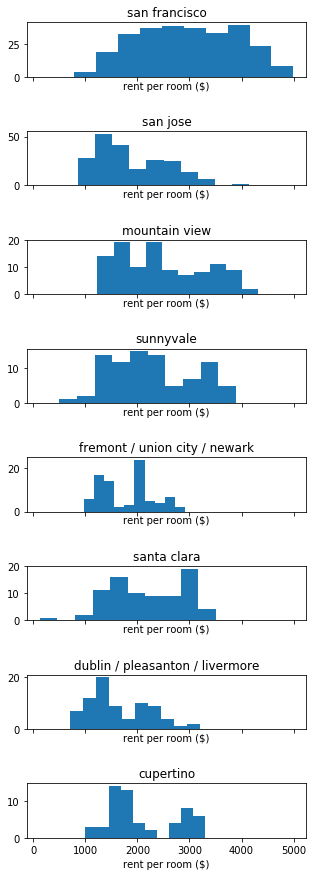

In [33]:
#plot price distributions for each neighborhood
fig,ax = plt.subplots(len(maxhoods),figsize=(5,15),sharex=True)
plt.subplots_adjust(hspace=1)
for i,nh in enumerate(maxhoods):
    ax[i].hist(dflim.loc[dflim['neighborhood']==nh]['rent per room'],bins=10)
    ax[i].set_title(nh)
    ax[i].set_xlabel('rent per room ($)')

In [34]:
# cm = plt.cm.get_cmap('tab10')
# colors = [cm(1.*i/10) for i in range(len(maxhoods))];
# cdict = dict(zip(maxhoods,colors))
# clist = [cdict[nh] for nh in maxhoods]


# fig,ax=plt.subplots(figsize=(12,12))

# nhcount=[]
# legendlist=[];
# for i,nh in enumerate(maxhoods):
#     dfnh=dfclean.loc[dfclean['neighborhood']==nh].sample(frac=1)
#     ax.scatter(dfnh['sq. feet'],dfnh['price'],c=clist[i])
#     legendlist.append(nh)
#     nhcount.append([nh,len(dfnh)])
# ax.legend(legendlist);#,bbox_to_anchor = (1,1));
# ax.set_xlabel('sq. feet');
# ax.set_ylabel('price ($)');

## fit a gaussian to rent per room data, for each neighborhood

In [35]:
#for each neighborhood, just fit price to a (1-dimensional) gaussian.


#dfsimple = dfclean[['rent per room']+maxhoods]
#dfsimple.head()

##split off some test data
#actually, no need, since i have no labels anyway.
dftrain=dflim[:]
#dftrain=dflim.sample(frac=.7)
#dftest = dflim.drop(dftrain.index)



Xnhs=[];
munh=[];
signh=[];
for nh in maxhoods:
    Xnh = dftrain.loc[dftrain['neighborhood']==nh]['rent per room'].values
    Xnhs.append(Xnh)
    munh.append(np.mean(Xnh));
    signh.append(np.std(Xnh));
    


In [36]:
print(f"The mean rent per room in San Francisco is ${np.round(munh[maxhoods.index('san francisco')],2)}.")

The mean rent per room in San Francisco is $2945.31.


But the price distributions tend to have long tails in the higher price ranges, which pulls the mean up. The most common prices are usually a bit below the mean. In a future iteration of this project, I'll try to account for this by using a skewed distribution.

In [37]:
#define gaussian in case i ever need it..
def gauss(x,mu,sig):
    pi=np.pi
    norm = ((2*pi)**.5)*sig
    exponent = (x-mu)**2/(2*sig**2)
    return np.exp(-exponent)/norm

## Flag listings with rent per room sufficiently below the neighborhood mean:

In [38]:
sigmas=1 #number of standard deviations from mean to be called an anomaly
def isitadeal(rent_per_room,nh): 
    mu = munh[ maxhoods.index(nh) ];
    sig = signh[ maxhoods.index(nh) ];
    if rent_per_room < mu - sigmas*sig:
        return(1)
    else:
        return(0)
    
#     if len(rent_per_room) != len(nh):
#         print('Oh no! Input arrays must be the same length.')
#     else:
#         prediction=np.zeros(len(rent_per_room))
#         prediction[rent_per_room < mu - sigmas*sig]  = 1


In [39]:
pp=dflim['rent per room'].values
nh = dflim['neighborhood'].values

predictions=np.zeros(len(dflim))
for i in range(len(pp)):
    predictions[i] = isitadeal(pp[i],nh[i])
    
dflim['deal?'] = predictions

print('Here are the (possible) deals or scams:')
dfdeals=dflim.loc[dflim['deal?']==1][['description','link','bedrooms','neighborhood','price','rent per room']].sort_values(by='rent per room')

dfdeals.head()

Here are the (possible) deals or scams:


,description,link,bedrooms,neighborhood,price,rent per room
1184,Brand new 1/1 furnished apt,https://sfbay.craigslist.org/sby/apa/d/santa-c...,1.0,santa clara,120.0,120.000000
1439,Find Your Perfect Apartment Home Here,https://sfbay.craigslist.org/sby/apa/d/mountai...,2.0,sunnyvale,1000.0,500.000000
2416,ELEGANT HOME FOR RENT IN THE LAWRENCE RANCH,https://sfbay.craigslist.org/eby/apa/d/tracy-e...,4.0,dublin / pleasanton / livermore,2850.0,712.500000
376,5 BEDROOM FLAT REMODELED BEST PRICE & LOCATION,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,5.0,san francisco,3950.0,790.000000
786,"Head-turning Style, Extraordinary Location.",https://sfbay.craigslist.org/eby/apa/d/tracy-h...,3.0,dublin / pleasanton / livermore,2395.0,798.333333


sanity check: Indeed, it seems homes with more rooms are cheaper per room.

In [40]:
NH = 'Sunnyvale'
NH = NH.lower().strip()


from IPython.core.display import display, HTML

#links= dfdeals.loc[dfdeals['neighborhood']==NH]['link'].values
#X = np.array(dfdeals.loc[dfdeals['neighborhood']==NH][['rent per room','neighborhood','bedrooms']])
links= dfdeals['link'].values
X = np.array(dfdeals[['rent per room','neighborhood','bedrooms']])


print('with links:')
#count=0
for i,x in enumerate(X):
    rent=x[0];
    nh=x[1];
    bedrooms=x[2];
    if isitadeal(rent,nh)==1:
        #print(f"A {x[1]} sq. foot {x[0]}-bedroom home for ${x[2]} is anomalous:")
        display(HTML("<a href="+links[i]+" target='_blank'> $"+str(np.round(rent))+" per room in a "+str(nh).capitalize()+" "+str(int(bedrooms))+"-bedroom. </a>"))
#        count=count+1

#print(count)


with links:


## TO DO:

Sometimes this misrepresents rent per room, e.g. if someone is renting out just 1 room in a 2-bedroom, and has listed rent for just the 1 room, but has posted the listing as a "2-bedroom". Can I find a way to correct this error by looking for particular words in the description/title?

In [ ]:
#plot the price distribution of 1-bedrooms from the training and test data

fig,ax =plt.subplots(1,1, figsize=(8,10))
ax.hist(dfclean.loc[dfclean['bedrooms']==1.0]['price']);
ax.set_xlabel('Price ($)');
ax.set_title('Price distribution for 1-bedrooms');



In [ ]:
dfclean.plot('bedrooms','sq. feet',kind = 'scatter')

In [ ]:
groupedbybedrooms = dfclean.groupby(by='bedrooms').mean();
plt.plot(groupedbybedrooms.index.values,groupedbybedrooms['sq. feet'],'o')
plt.xlabel('number of bedrooms')
plt.ylabel('mean area (ft$^2$)')

In [ ]:
#train for anomaly detection and make predictions


# #compute the mean
# mu = train[['bedrooms','1000sqfeet', 'pricek']].mean().values
# #mu = np.array(np.mean(train)[['bedrooms','1000sqfeet','pricek']])
# xminusmu = np.array(train[['bedrooms','1000sqfeet', 'pricek']]-mu)

# #compute covariance matrix
# m=xminusmu.shape[0]
# Sigi=0;
# for i in range(0,m):
#     Sigi=Sigi+np.outer(xminusmu[i], (xminusmu[i]).T)
# Sig=(1/m)*Sigi
# detSig = np.linalg.det(Sig)

# Siginv = np.linalg.inv(Sig)
# n=len(mu)
# def p(x):
#     #p takes x in [bedrooms, square feet, dollars]
#     y=np.array([x[0],x[1]/1000,x[2]/1000]) #convert to 1000s of sq feet, 1000s of dollars
#     exp=np.e**(-.5*np.dot(y-mu,np.dot(Siginv,y-mu)))
#     return(exp/( (2*np.pi)**(n/2)*(detSig**(1/2)) ))


def multigauss(X,mu,Sig):  #input X is m by n (must be in the form of a 2-d array). inputs (X, mu, Sig) should be in 1000sqfeet, 1000$.
        #if mu[1]>X[0,1]*10 or mu[1]<X[0,1]/10:
        #    print('Make sure mu and X are in the same units.')
        n = X.shape[1];
        m = X.shape[0];
        Xminusmu = X-mu
        pi = np.pi
        det = np.linalg.det(Sig)
        inv = np.linalg.inv(Sig)
        exponent=-.5*np.reshape([np.dot( (X[i,:]-mu),  np.dot(inv,(X[i,:]-mu).T)) for i in range(0,m)],(m,1))
        return np.reshape(((2*pi)**(-.5*n))*(det**-.5)*np.exp(exponent),(m,))
    
    
#CHANGE FEATURES HERE 
featureset = ['bedrooms','pricek'];
n = len(featureset)


#fit mu, Sig for each neighborhood separately
nhmu = np.zeros((len(maxhoods),n))
nhSig = np.zeros((len(maxhoods),n,n))
for i,nh in enumerate(maxhoods):
    if type(nh)==str:
        #print(nh)
        dfnh = train.loc[train['neighborhood']==nh]
        if len(dfnh) is not 0:
            Xtrain = np.array(dfnh[featureset])
            m = Xtrain.shape[0]
            mu = np.mean(Xtrain,0)
            Xminusmu=Xtrain-mu
            Sig=(1/m)*np.dot(Xminusmu.T,Xminusmu)
            nhmu[i] = mu
            nhSig[i] = Sig
        else:
            nhmu[i]=np.nan
            nhSig[i]=np.nan
    else:
        nhmu[i]=np.nan
        nhSig[i]=np.nan
    

    
    
    


In [ ]:
#e.g. mu and sigma for sunnyvale:
svmu=nhmu[maxhoods.index('sunnyvale')]
svSig=nhSig[maxhoods.index('sunnyvale')]

def svp(X):
    return multigauss(X,svmu,svSig)

svtest = test.loc[test['neighborhood']=='sunnyvale'][:]


svXtest=svtest[featureset].values


svtest['probability'] = svp(svXtest)
svtest[['description']+featureset+['probability']].sort_values(by='probability')


## dont' know why this is not normalized how I expect --- come back to this later

In [ ]:
brrange = np.arange(min(dfsv['bedrooms']),max(dfsv['bedrooms']+1))
pprange = np.arange(min(dfsv['pricek']),max(dfsv['pricek']+1),.1)

plt.hist(dfsv['pricek'])
plt.plot(pprange,[len(dfsv['pricek'])*np.sum([multigauss(np.array([[br,pp]]),svmu,svSig) for br in brrange]) for pp in pprange])


In [ ]:
#this seems fine:

plt.hist(dfsv.loc[dfsv['bedrooms']==1]['pricek'])
plt.plot(pprange,[len(dfsv.loc[dfsv['bedrooms']==1])*multigauss(np.array([[1,pp]]),svmu,svSig) for pp in pprange])


In [ ]:
dfsv = train.loc[train['neighborhood']=='sunnyvale']

pprange = np.arange(0,6,.1);
plt.hist(dfsv['price'])
plt.plot(1000*pprange,np.array([np.sum([svp(np.array([[br,pp]])) for br in range(1,4)]) for pp in pprange]))
plt.xlabel('rent ($)')
plt.title('price distribution for all homes in sunnyvale (training set)');




Expected price given bedrooms and square footage: (want to use this to pick only anomalies where price is lower than expected)

In [ ]:
XY[:,0]

In [ ]:
X = [0,0,0,1,1,1,1,2,3];
Y = [0,1,1,0,2,2,2,3,10];

XY = np.array([X,Y]).T



def gauss(x):
    xmu=np.mean(X);
    xsig=np.std(X);
    return((1/(((2*np.pi)**.5)*xsig))*np.exp(-(x-xmu)**2/(2*xsig**2)))

muXY=np.mean(XY,axis=0)



m=len(X);
SigXY=(1/m)*np.dot((XY-muXY).T,XY-muXY)

def multigaussXY(x,y):
    return multigauss(np.array([[x,y]]),muXY,SigXY)

xrange = np.arange(min(X),max(X)+1);
yrange = np.arange(min(Y),max(Y)+1);

plt.hist(Y)
plt.plot(yrange, [len(XY)*np.sum([multigaussXY(x, y) for x in xrange]) for y in yrange] )

In [ ]:
brrange=list(set(dfsv['bedrooms']));
print(brrange)
.1*np.sum([np.sum([svp(np.array([[br,pp]])) for br in brrange]) for pp in pprange])

(or see below for the quick and dirty method of finding expected price)

In [ ]:
bdrs = 1;
ksqfeet = 1;

pricerange = np.arange(0,50,.1);
probprice=[p(np.array([[bdrs, ksqfeet, kdollars]]), mu, Sig) for kdollars in pricerange]
maxid = np.argmax(probprice)


pricerange[maxid]*1000

Now define function using this to say whether a given price is cheap:

In [ ]:
def isitcheap(X,mu,Sig):
    m=X.shape[0]
    n=X.shape[1]
    
    br = X[:,0]
    sqft = X[:,1]
    price = X[:,2]
    
    dz = 1;
    zmax = 100;
    pricerange = np.arange(0,zmax,dz);
    
    norm = np.zeros(m)
    exp_price = np.zeros(m)
    
    for i in range(0,m):
        norm[i] = dz*np.sum([p(np.array([[br[i],sqft[i],z]]),mu,Sig) for z in pricerange]);
        exp_price[i] = dz*np.sum([z*p(np.array([[br[i],sqft[i],z]]),mu,Sig) for z in pricerange])/norm[i];
    
    return price<exp_price
#returns "True" if price is lower than expected given br and sqft

In [ ]:
#define expected price seprately
def exp_price(br,sqft,mu,Sig):
    norm = dz*np.sum([p(np.array([[br,sqft,z]]),mu,Sig) for z in pricerange]);
    exp_price = dz*np.sum([z*p(np.array([[br,sqft,z]]),mu,Sig) for z in pricerange])/norm;
    return exp_price

In [ ]:
exp_price(4,1.15,mu,Sig)*1000

### Define probability density for price, given fixed number of bedrooms and square footage.

In [ ]:
br = 1;
sqft = 1;

dz=.1;
zmax = 8;
    
def pz(x0,y0,z):

    norm=dz*np.sum([p(np.array([[1,1,z]]),mu,Sig) for z in np.arange(0,zmax,dz)]);
    return p(np.array([[x0,y0,z]]),mu,Sig)/norm

#plt.plot(pricerange,[pz(1,1,z) for z in pricerange])

pricerange=np.arange(0,zmax,dz)
pzrange=np.reshape([pz(1,1,z) for z in pricerange],(len(pricerange),));

plt.plot(pricerange*1000,pzrange)
plt.xlabel('Price ($)')
plt.title(f'(Normalized) distribution for price, for {br}-bedroom, {sqft*1000} sq-foot homes')

In [ ]:
start = time.time()
dz*np.sum([pz(br,sqft,z)*z for z in pricerange])
end = time.time()
end-start

This can the be used to get expected price given bedrooms and area.

In [ ]:
smallp=(p(Xval,mu,Sig)<.05)[:,0]

Xvalsmallp=Xval[smallp]

val['probability'] = p(Xval,mu,Sig)[:,0]

val[ (val['probability']<0.01)][val['pricek']<mu[2] ]

#need another filter, for /low/ price given other features.



## predict

In [ ]:
#first use validation to set epsilon
eps = .02

def predict(x,mu,Sig): #input x is m by n (must be in the form of a 2-d array)
    m = x.shape[0]
    prediction=np.ones(m)
    prediction[p(x,mu,Sig)>eps] = 0
    prediction[isitcheap(x,mu,Sig)==False]=0
    return prediction

#         if isitcheap(x,mu,Sig)==True:
#             return True
#         else:
#             return False


Xtest = np.array(test[['bedrooms','1000sqfeet','pricek']])
testpred=predict(Xtest,mu,Sig)
testpred = testpred.astype(bool)

In [ ]:
test['probability']= p(Xtest,mu,Sig)

In [ ]:
test[testpred].sort_values(by='probability')[['description','link','bedrooms','sq. feet', 'price', 'probability']]

In [ ]:
x = np.array([[1,0],[1,1],[3,2]]);
m=x.shape[0]
n = x.shape[1]
mu = np.reshape(np.mean(x,0),(1,n))

xminusmu = x-mu

Sig = (1/m)*np.dot(xminusmu.T,xminusmu) 
inv = np.linalg.inv(Sig)

x0 = x[0,:]

#np.exp(-.5*([np.dot( (x[i,:]-mu),  np.dot(inv,(x[i,:]-mu).T)) for i in range(0,m)]))

exponent=-.5*np.reshape([np.dot( (x[i,:]-mu),  np.dot(inv,(x[i,:]-mu).T)) for i in range(0,m)],(m,1))
np.exp(exponent)

In [ ]:
#time to look for anomalies in the test data

test.head()

#put the test data into an array of x's:
testarray_links= np.array(test['link'])
testarray = np.array(test[['bedrooms','sq. feet', 'price']])

y=np.zeros(len(testarray))
for i,x in enumerate(testarray):
    y[i] = predict(x,mu,Sig)
    if predict(x)==1:
        print(f"A {x[1]} sq. foot {x[0]}-bedroom home for ${x[2]} is anomalous:")
        display(HTML("<a href="+testarray_links[i]+" target='_blank'>see link</a>"))
        
#at this stage, i think too many things are being flagged as anomalous, e.g. many-roomed homes, even if not particularly expensive per room.

In [ ]:
testnotforsale=test.drop(test[test['price']>50000].index)
type(testnotforsale)

In [ ]:
test[y==1].plot('sq. feet', 'price',kind='scatter',color='r')
test[y==0].plot('sq. feet', 'price',kind='scatter',color='b')

In [ ]:
#complex p?

In [ ]:



#fix to 1 bedrooms and look at probability distribution in the two dimensions of square footage and price
sqfeetrange = np.arange(0,5000,100);
pricerange = np.arange(0,10000,100);
X, Y = np.meshgrid( sqfeetrange, pricerange);

Z = np.array([[p(np.array([1,x,y]),mu,Sig) for x in sqfeetrange] for y in pricerange])




from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()



ax = fig.gca(projection='3d')

ax.scatter([1000],[4000],p(np.array([1,1000,4000]),mu,Sig),color='k',marker = 'o')

surf = ax.plot_surface(X, Y, Z)#, cmap=cm.coolwarm)#,
                       #linewidth=0, antialiased=False)
ax.set_xlabel('sq. feet')
ax.set_ylabel('price')



In [ ]:
np.sqrt(detSig)

In [ ]:
#average price per room for 1 br, 2br, 3br
#[np.mean(df.loc[df['bedrooms']==i]['price'])/i for i in range(1,6)]

In [ ]:
#df.loc[df['price']>5000]

In [ ]:
# old train and predict

#remove rows with missing data
# dfclean=df_no_duplicates.dropna()[:]

# dfclean['1000sqfeet']=dfclean['sq. feet']/1000  #normalize so all features are order 1 (no area is in 1000s of square feet)
# dfclean['pricek']=dfclean['price']/1000 #normalize so all features are order 1 (price is in thousands of dollars)

# #compute the mean
# mu = np.array(np.mean(dfclean)[['bedrooms','1000sqfeet','pricek']])
# xminusmu = np.array(dfclean[['bedrooms','1000sqfeet', 'pricek']]-mu)

# #compute covariance matrix
# m=xminusmu.shape[0]
# Sigi=0;
# for i in range(0,m):
#     Sigi=Sigi+np.outer(xminusmu[i], (xminusmu[i]).T)
# Sig=(1/m)*Sigi
# detSig = np.linalg.det(Sig)

# Siginv = np.linalg.inv(Sig)
# n=len(mu)
# def p(x):
#     #p takes x in [bedrooms, 1000s of square feet, 1000s of dollars]
#     exp=np.e**(-.5*np.dot(x-mu,np.dot(Siginv,x-mu)))
#     return(exp/( (2*np.pi)**(n/2)*(detSig**(1/2)) ))
    
# #set a 1-sigma cut-off?
# def predict(x):
#     #x = [bedrooms, square feet, price (in dollars)]
#     eps = p(mu-[Sig[0,0],(Sig[1,1]),Sig[2,2]  ]);
#     y = np.array([x[0], x[1]/1000, x[2]/1000])
#     if p(y)>=eps:  #p takes x in [bedrooms, 1000s of square feet, 1000s of dollars]
#         print(f"A {np.round(x[1])} sq. foot {int(x[0])}-bedroom home for ${np.round(x[2],2)} is not anomalous.")
#     else:
#         print(f"A {x[1]} sq. foot {x[0]}-bedroom home for ${x[2]} is anomalous.")    
    

In [ ]:
pricerange = np.arange(0,int(max(dfclean['pricek'])),.1);
xs = [[1,.8,price] for price in pricerange]
plt.plot([price for price in pricerange], [p(xs[i]) for i in range(0,len(xs))])
plt.xlabel('Price (k$)')
plt.title('Probability distribution for average bedrooms and area, as a functin of price')


In [ ]:
x=np.zeros(3);
x[0]=1
x[1]=np.mean(dfclean.loc[dfclean['bedrooms']==x[0]]['1000sqfeet'])
x[2] = .5
x=np.array(x)
print(f"Check probability of feature vector {x}")
print(f"There's a {np.round(p(x)*100,2)}% chance that a {int(x[0])}-bedroom of average size \nwould cost ${x[2]*1000}. This is somewhat anomalous.")

In [ ]:
predict(np.array([3,1000,3500]))

In [ ]:
#now i need to get more data by scraping other pages,
# and properly split my data into training/testing (don't think i need CV for anything?)

In [ ]:
re.compile('[a-z ]+').search(resultrow.find(class_="result-hood").text.strip()).group() for resultrow in resultrows


In [ ]:
lowerpachts=resultrows[3].find(class_="result-hood").text.strip()

re.compile('[a-z ]+').findall(lowerpachts)

In [ ]:
resultrows.find_all(class_="result-hood")

# other cleaning considerations

In [ ]:

#plenty list price zero. obviously this is false.
df[df['price']==0]

#extract the most expensive neighborhoods?

nhp=[];
for nh in hoods:
    nhp.append([nh, np.mean(df[df['neighborhood']==nh]['price'])])
    
    
pd.DataFrame(nhp,columns=['neighborhood','average price']).sort_values(by='average price',ascending=False)
